# TP Recurrent Neural Network/LSTM : part. 1

#Imports

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pandas as pd 
import pandas_datareader.data as data_reader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.models import model_from_json
from tensorflow import keras

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 4.4MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=3864b4de4585bd604fecbee4086ecba45e1c2fd735f8df57a6d4a59b913de692
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=513285a2ce545c9cd00f1ee8314722893b5b4206a4aba852e82e356653a18d8e
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Importation

In [ ]:
data_train = data_reader.get_data_yahoo("SAN.PA", "3/1/2017", "29/1/2021")['Close']
data_test = data_reader.get_data_yahoo("SAN.PA", "1/2/2021", "26/2/2021")['Close']

In [ ]:
print("Train Dimensions: ", data_train.shape)
print("Test Dimensions: ", data_test.shape)

Train Dimensions:  (1001,)
Test Dimensions:  (40,)


In [ ]:
data_train.head()

Date
2017-03-01    82.820000
2017-03-02    82.639999
2017-03-03    83.589996
2017-03-06    82.449997
2017-03-07    81.800003
Name: Close, dtype: float64

In [ ]:
data_test.head()

Date
2021-01-04    79.000000
2021-01-05    78.989998
2021-01-06    78.510002
2021-01-07    77.720001
2021-01-08    78.790001
Name: Close, dtype: float64

In [ ]:
print("Train missing values :", data_train.isna().sum())
print("Test missing values :", data_test.isna().sum())

Train missing values : 0
Test missing values : 0


Importation ok. **No Missing values**.

#Univariate analysis

## Basic statistics

In [ ]:
data_train.describe()

count    1001.000000
mean       79.629690
std         7.338636
min        63.209999
25%        74.500000
50%        79.480003
75%        85.059998
max        94.290001
Name: Close, dtype: float64

In [ ]:
data_test.describe()

count    40.000000
mean     79.067750
std       1.834064
min      75.650002
25%      77.982500
50%      78.910000
75%      80.627501
max      83.230003
Name: Close, dtype: float64

## Univariate distribution according to time

In [ ]:
data_train

Date
2017-03-01    82.820000
2017-03-02    82.639999
2017-03-03    83.589996
2017-03-06    82.449997
2017-03-07    81.800003
                ...    
2021-01-25    81.500000
2021-01-26    81.070000
2021-01-27    79.070000
2021-01-28    79.089996
2021-01-29    77.150002
Name: Close, Length: 1001, dtype: float64

In [ ]:
def plot_time_series(data_train, data_test, name = 'Close'):

    _ = data_test \
    .rename(columns={name: 'TEST SET'}) \
    .join(data_train.rename(columns={name: 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), style='-')
    title(name)
    show()

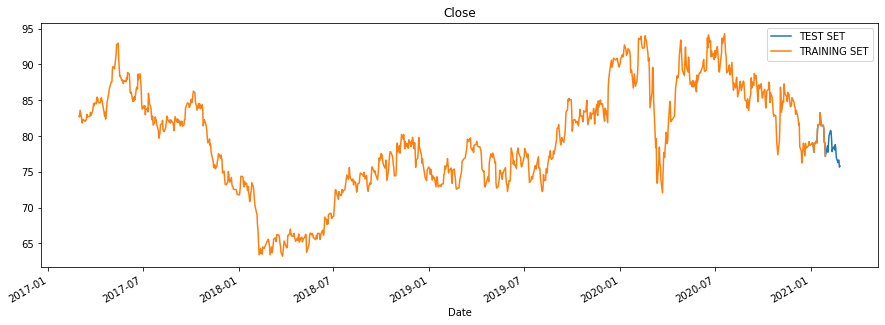

In [ ]:
plot_time_series(data_train = pd.DataFrame(data_train, columns = ['Close']), data_test = pd.DataFrame(data_test, columns = ['Close']))

# Preprocessor



## Removing date information

In [ ]:
y_test = array(data_test.copy())

## Add lag

In [ ]:
def get_Xy(data, lag = 60):
  X = []
  y = array(data.copy())

  assert lag + 1 < data.shape[0], 'Too much lag!'

  for i in range(1, lag + 1):
    X.append(array(data.shift(i)))

  df = pd.DataFrame(array(X)).transpose()
  df = df.dropna()
  #print(df)

  return df.values, y[lag:], 

In [ ]:
X_train, y_train = get_Xy(data_train, 60)

In [ ]:
X_train.shape

(941, 60)

In [ ]:
y_train.shape

(941,)

## Min/max scaling

In [ ]:
min_y = min(y_train)
max_y = max(y_train)
y_train = (y_train - min(y_train))/(max(y_train) - min(y_train))

scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)

In [ ]:
X_train

array([[0.78925345, 0.77541818, 0.78474897, ..., 0.65572703, 0.62516085,
        0.63095236],
       [0.78539261, 0.78925345, 0.77541818, ..., 0.61904751, 0.65572703,
        0.62516085],
       [0.78346194, 0.78539261, 0.78925345, ..., 0.59813394, 0.61904751,
        0.65572703],
       ...,
       [0.57464606, 0.58848133, 0.5871943 , ..., 0.75933067, 0.59362946,
        0.52027018],
       [0.510296  , 0.57464606, 0.58848133, ..., 0.72265115, 0.75933067,
        0.59362946],
       [0.51093939, 0.510296  , 0.57464606, ..., 0.64703988, 0.72265115,
        0.75933067]])

In [ ]:
y_train

array([0.78539261, 0.78346194, 0.80308873, 0.79375794, 0.82561139,
       0.81981988, 0.79214933, 0.73584303, 0.73262558, 0.73777345,
       0.69626764, 0.71203333, 0.69658945, 0.71653806, 0.70302436,
       0.75579139, 0.75965248, 0.75128691, 0.81853285, 0.79343636,
       0.82014145, 0.78571418, 0.75579139, 0.68629345, 0.66119697,
       0.67535382, 0.66441442, 0.67599745, 0.63577867, 0.65797952,
       0.66570146, 0.64832691, 0.73198194, 0.70817249, 0.68758049,
       0.662484  , 0.623552  , 0.61229079, 0.62934351, 0.58912473,
       0.60167321, 0.62612606, 0.61518667, 0.61132558, 0.59137697,
       0.56338485, 0.53024461, 0.54086218, 0.55373224, 0.59202061,
       0.59427285, 0.61036036, 0.5672457 , 0.56595891, 0.55952376,
       0.57786351, 0.59716848, 0.62323042, 0.62902194, 0.61293443,
       0.60135139, 0.61229079, 0.59813394, 0.61229079, 0.6077863 ,
       0.59909915, 0.58590727, 0.56435006, 0.59362946, 0.62741309,
       0.6061777 , 0.60263843, 0.61679527, 0.60231661, 0.61132

## Dimensions

In [ ]:
X_train = reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(941, 60, 1)

# 1st NN

## Modelization

In [ ]:
model1 = Sequential()

#Input layer
#50 neurals, 20% dropout
model1.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model1.add(Dropout(0.2))

#3 hidden layers
#50 neurals, 20% dropout
for i in range (2):
  model1.add(LSTM(units = 50, return_sequences = True))
  model1.add(Dropout(0.2))
model1.add(LSTM(units = 50, return_sequences = False))
model1.add(Dropout(0.2))

#Output layer
#1 neural
model1.add(Dense(units = 1))

#Compilation
#optimizer : Adam, loss: MSE
model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

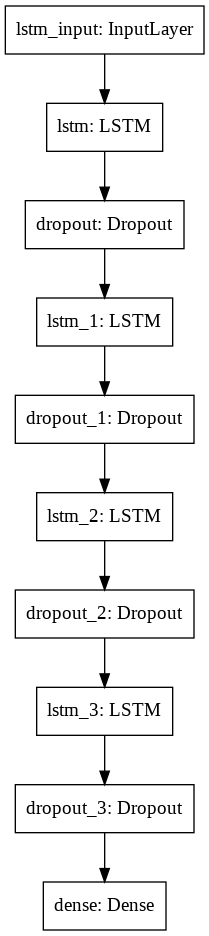

In [ ]:
plot_model(model1)

In [ ]:
model1.fit(x = X_train, y = y_train, batch_size = 32, epochs = 50)

Epoch 1/50
30/30 [==============================] - 10s 104ms/step - loss: 0.0888
Epoch 2/50
30/30 [==============================] - 3s 108ms/step - loss: 0.0260
Epoch 3/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0258
Epoch 4/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0218
Epoch 5/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0224
Epoch 6/50
30/30 [==============================] - 3s 110ms/step - loss: 0.0129
Epoch 7/50
30/30 [==============================] - 3s 108ms/step - loss: 0.0171
Epoch 8/50
30/30 [==============================] - 3s 109ms/step - loss: 0.0119
Epoch 9/50
30/30 [==============================] - 3s 108ms/step - loss: 0.0120
Epoch 10/50
30/30 [==============================] - 3s 109ms/step - loss: 0.0119
Epoch 11/50
30/30 [==============================] - 3s 111ms/step - loss: 0.0114
Epoch 12/50
30/30 [==============================] - 3s 111ms/step - loss: 0.0113
Epoch 13/50
30/30 [=====

In [ ]:
model1.predict(X_train).shape

(941, 1)

In [ ]:
X_train.shape

(941, 60, 1)

## Predictions & assesment

Rk : The notebook viewed in class and most of basic LSTM examples found in Internet use y_test(n) to predict y_test(n+1). In order to build a realistic predictive model we must use y_pred(n) to predict y_test(n+1)!

In [ ]:
def get_predictions(n, X_train, y_train, model) :
  
  y = zeros(n) #output
  last_y = y_train[- 1] #not in X_train!
  last_X = X_train[-1, :, 0]

  for i in range(n):
    Xtest = zeros(last_X.shape)
    Xtest[1:] = last_X[1:]
    Xtest[0] = last_y
    tmp = model.predict(Xtest.reshape(1, X_train.shape[1], 1))
    last_X = Xtest
    last_y = tmp[0]
    y[i] = last_y

  return array(y)

In [ ]:
y_pred_invscaled = (max_y - min_y) * get_predictions(len(y_test), X_train, y_train, model1) + min_y

In [ ]:
y_pred_invscaled

array([81.95320154, 82.75608415, 82.89126013, 82.91404233, 82.91788259,
       82.91852726, 82.91864027, 82.91865879, 82.91866064, 82.91866064,
       82.91866064, 82.91866064, 82.91866064, 82.91866064, 82.91866064,
       82.91866064, 82.91866064, 82.91866064, 82.91866064, 82.91866064,
       82.91866064, 82.91866064, 82.91866064, 82.91866064, 82.91866064,
       82.91866064, 82.91866064, 82.91866064, 82.91866064, 82.91866064,
       82.91866064, 82.91866064, 82.91866064, 82.91866064, 82.91866064,
       82.91866064, 82.91866064, 82.91866064, 82.91866064, 82.91866064])

In [ ]:
y_test

array([79.        , 78.98999786, 78.51000214, 77.72000122, 78.79000092,
       79.23999786, 79.19000244, 79.02999878, 80.97000122, 81.52999878,
       81.62999725, 83.23000336, 82.34999847, 81.41999817, 81.45999908,
       81.5       , 81.06999969, 79.06999969, 79.08999634, 77.15000153,
       78.20999908, 78.59999847, 77.73000336, 78.83000183, 80.01000214,
       80.76999664, 80.58000183, 79.45999908, 77.80999756, 78.16000366,
       78.54000092, 78.04000092, 78.77999878, 78.23999786, 77.01000214,
       76.30000305, 76.62000275, 76.62999725, 75.65000153, 75.80000305])

In [ ]:
print("##########R2########")
print(r2_score(y_pred_invscaled, y_test))
print("########MSE#########")
print(mean_squared_error(y_pred_invscaled, y_test))
print("######RMSE########")
print(sqrt(mean_squared_error(y_pred_invscaled, y_test)))

##########R2########
-772.7387528610018
########MSE#########
17.90465912045309
######RMSE########
4.231389738661885


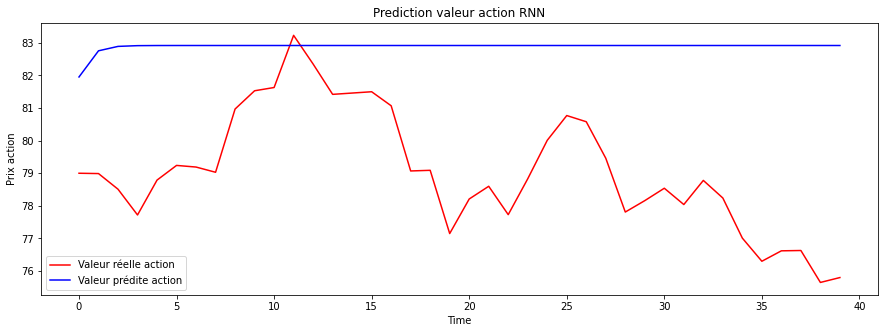

In [ ]:
figure(figsize=(15,5))
plot(y_test, color = 'red', label = 'Valeur réelle action')
plot(y_pred_invscaled, color = 'blue', label = 'Valeur prédite action')
title('Prediction valeur action RNN')
xlabel('Time')
ylabel('Prix action')
legend()
show()

Rk:

- The r2 is not even in 0-1, it tells us that we should predict y_test by its mean (that we could not compute in a true prediction model).

- Because of the use of predictions to predict, the model stucks itself at a point and starts predicting always the same thing...

**DO NOT RUN**

# Tuned NN

**DO NOT RUN**

## Validation data set

In [ ]:
X_val = X_train[-40:, :]
y_val = y_train[-40:]

In [ ]:
X_train2 = X_train[:-40, :]
y_train2 = y_train[:-40]

In [ ]:
X_val.shape

(40, 60, 1)

In [ ]:
X_train2.shape

(901, 60, 1)

In [ ]:
X_train.shape

(941, 60, 1)

## Architecture

In [ ]:
## CHANGE tuning params here
max_trials = 15
executions_per_trial = 3
epochs = 30 #will be tuned later
dir = ""
name = "final"

In [ ]:
def build_model(hp):
    #Sequental NN
    model = Sequential()
    #1 input layer with 60 units
    model.add(LSTM(units = 60, activation = "tanh", input_shape = (X_train.shape[1], 1), return_sequences=True))
    #Between 0 & 9 hidden layers
    for i in range(hp.Int('num_layers', 0, 9)):
        #between 10 & 50 neurals
        model.add(LSTM(units=hp.Int('units_' + str(i),
                                            min_value=10,
                                            max_value=50),
                              activation='tanh',
                              recurrent_activation = "sigmoid",
                              return_sequences = True,
                              recurrent_dropout = hp.Choice('dropout', [0., 0.1, 0.25, 0.5])))
    #1 hidden layer with 1 state
    model.add(LSTM(units=hp.Int('units_' + 'last',
                                            min_value=10,
                                            max_value=50),
                              activation='tanh',
                              recurrent_activation = "sigmoid",
                              recurrent_dropout = hp.Choice('dropout', [0., 0.1, 0.25, 0.5])))
    
    #Final layer activation = relu
    model.add(Dense(1, activation="tanh"))
    #Different learning rates
    model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate', [1e-3, 1e-2, 1e-1])),
        loss='mean_squared_error')
    
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective = "val_loss",
    max_trials=max_trials,
    executions_per_trial=executions_per_trial,
    directory=dir,
    project_name=name)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 9, 'step': 1, 'sampling': None}
units_last (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 1, 'sampling': None}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.25, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}


In [ ]:
tuner.search(X_train, y_train, validation_data = (X_val, y_val), epochs = epochs)

In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

In [ ]:
#SAVE
###################
##DO NOT RUN#######
###################
model = tuner.hypermodel.build(best_hps)
model_json = model.to_json()
with open("model_rnn.json", "w") as json_file:
    json_file.write(model_json)
with open("/content/drive/MyDrive/"+"model_rnn.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
tuner.results_summary()

Results summary
Results in ./final
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 7
units_last: 24
dropout: 0.5
learning_rate: 0.001
units_0: 24
units_1: 45
units_2: 36
units_3: 47
units_4: 18
units_5: 10
units_6: 10
Score: 0.002473225506643454
Trial summary
Hyperparameters:
num_layers: 2
units_last: 30
dropout: 0.0
learning_rate: 0.01
units_0: 14
units_1: 15
units_2: 41
units_3: 13
units_4: 33
units_5: 17
units_6: 45
units_7: 49
Score: 0.002944613302436968
Trial summary
Hyperparameters:
num_layers: 4
units_last: 38
dropout: 0.0
learning_rate: 0.01
units_0: 20
units_1: 15
units_2: 15
units_3: 16
units_4: 19
units_5: 35
units_6: 28
units_7: 12
Score: 0.0029875849528859058
Trial summary
Hyperparameters:
num_layers: 5
units_last: 18
dropout: 0.25
learning_rate: 0.01
units_0: 19
units_1: 17
units_2: 46
units_3: 48
units_4: 16
Score: 0.0030040330408761897
Trial summary
Hyperparameters:
num_layers: 3
units_last: 49
dropout: 0.5
l

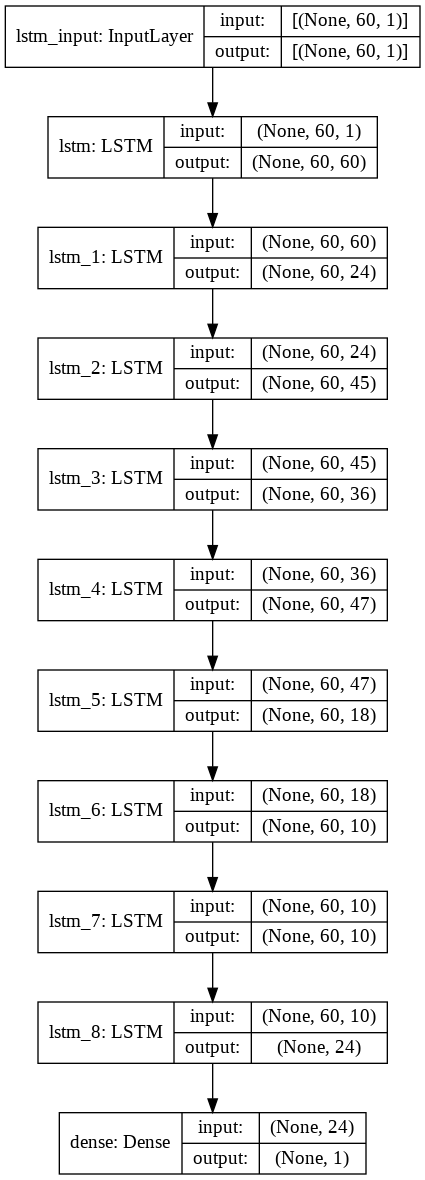

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Learning parameters tuning

In [ ]:
json_file = open('/content/drive/MyDrive/model_rnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
model = loaded_model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error')

In [ ]:
summary = []
params = [50, 100, 200]
start_time = time.time()
total_time = 0
for param in  params:
  #Info
  print("######################")
  print("batch size: ", param)

  history = model.fit(X_train, 
                      y_train, 
                      epochs=150, 
                      validation_data = (X_val, y_val), 
                      batch_size = param, 
                      verbose = 0,
                      workers = 4,
                      use_multiprocessing = True)
  
  val_loss_per_epoch = history.history['val_loss']
  best_epoch = val_loss_per_epoch.index(max(val_loss_per_epoch)) + 1
  summary.append([best_epoch, max(val_loss_per_epoch)])

  #Info
  print('Best epoch: %d' % (best_epoch,))
  print("Corresponding val MSE :", max(val_loss_per_epoch))
  current_time = time.time()
  print("Iteration finished, time ellapsed:", current_time - start_time)
  total_time += current_time - start_time
  print("Total time ellapsed:", total_time)
  start_time = current_time
  print("######################")
  

print("_______________________")
print("_______________________")
print(summary)

######################
batch size:  50
Best epoch: 7
Corresponding val MSE : 0.038209278136491776
Iteration finished, time ellapsed: 1200.2007427215576
Total time ellapsed: 1200.2007427215576
######################
######################
batch size:  100
Best epoch: 37
Corresponding val MSE : 0.003046163124963641
Iteration finished, time ellapsed: 758.5945191383362
Total time ellapsed: 1958.7952618598938
######################
######################
batch size:  200
Best epoch: 139
Corresponding val MSE : 0.0021734151523560286
Iteration finished, time ellapsed: 535.2953810691833
Total time ellapsed: 2494.090642929077
######################
_______________________
_______________________
[[7, 0.038209278136491776], [37, 0.003046163124963641], [139, 0.0021734151523560286]]


In [ ]:
def plot_learning_information(info, name, plot_title):
  figure(figsize = (10,10))
  plot(range(1, len(info)+1), info)
  title(plot_title)
  xlabel("Number of epochs")
  ylabel(name)
  show()

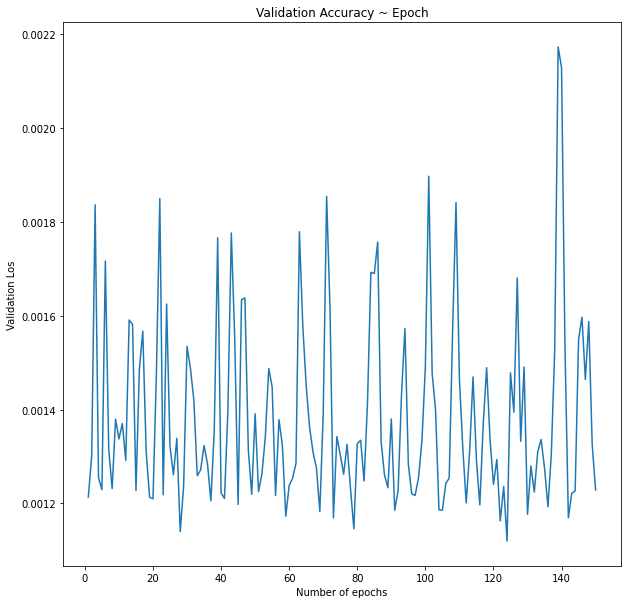

In [ ]:
plot_learning_information(val_loss_per_epoch, "Validation Los", "Validation Accuracy ~ Epoch")

In [ ]:
summary = array(summary)
epoch = int(summary[argmax(summary[:,1]),:][0])
print(epoch)
batch = int(params[argmax(summary[:,1])])
print(batch)
model.fit(X_train, 
          y_train, 
          epochs=epoch, 
          validation_data = (X_val, y_val), 
          batch_size = batch,
          workers = 8,
          use_multiprocessing = True)

7
50
Epoch 1/7
19/19 [==============================] - 8s 417ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 2/7
19/19 [==============================] - 8s 426ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/7
19/19 [==============================] - 8s 441ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/7
19/19 [==============================] - 9s 461ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/7
19/19 [==============================] - 8s 439ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/7
19/19 [==============================] - 8s 446ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/7
19/19 [==============================] - 8s 410ms/step - loss: 0.0015 - val_loss: 0.0014


In [ ]:
#SAVE
################################
############DO NOT RUN##########
################################
model_json = model.to_json()
with open("trained_model_rnn.json", "w") as json_file:
    json_file.write(model_json)
with open("/content/drive/MyDrive/"+"trained_model_rnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/model_rnn.weights")
model.save_weights("model_rnn.weights")
print("Saved model to disk")

Saved model to disk


## Assessment

In [ ]:
def get_predictions(n, X_train, y_train, model) :
  
  y = zeros(n) #output
  last_y = y_train[- 1] #not in X_train!
  last_X = X_train[-1, :, 0]

  for i in range(n):
    Xtest = zeros(last_X.shape)
    Xtest[1:] = last_X[1:]
    Xtest[0] = last_y
    tmp = model.predict(Xtest.reshape(1, X_train.shape[1], 1))
    last_X = Xtest
    last_y = tmp[0]
    y[i] = last_y

  return array(y)

In [ ]:
y_pred_invscaled = (max_y - min_y) * get_predictions(len(y_test), X_train, y_train, model) + min_y

In [ ]:
print("##########R2########")
print(r2_score(y_pred_invscaled, y_test))
print("########MSE#########")
print(mean_squared_error(y_pred_invscaled, y_test))
print("######RMSE########")
print(sqrt(mean_squared_error(y_pred_invscaled, y_test)))

##########R2########
-37.899305671126136
########MSE#########
3.7410504455222577
######RMSE########
1.9341795277383786


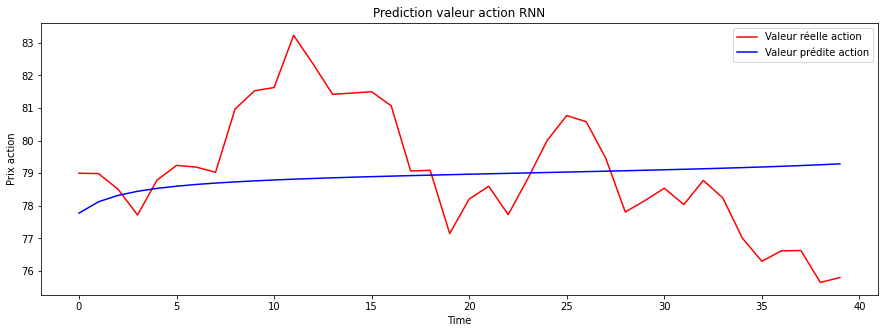

In [ ]:
figure(figsize=(15,5))
plot(y_test, color = 'red', label = 'Valeur réelle action')
plot(y_pred_invscaled, color = 'blue', label = 'Valeur prédite action')
title('Prediction valeur action RNN')
xlabel('Time')
ylabel('Prix action')
legend()

At least, the tuned model has done better than our prior architecture.